<a href="https://www.kaggle.com/code/patimejia/global-food-security?scriptVersionId=140230864" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Main Function and Execution

#### Print Directory Information

Current working directory:  /kaggle/working
Directory content:  ['__notebook__.ipynb']
Directory content:  ['food-security-organizations-directory']


### Visualizations

#### Word Cloud of Descriptions

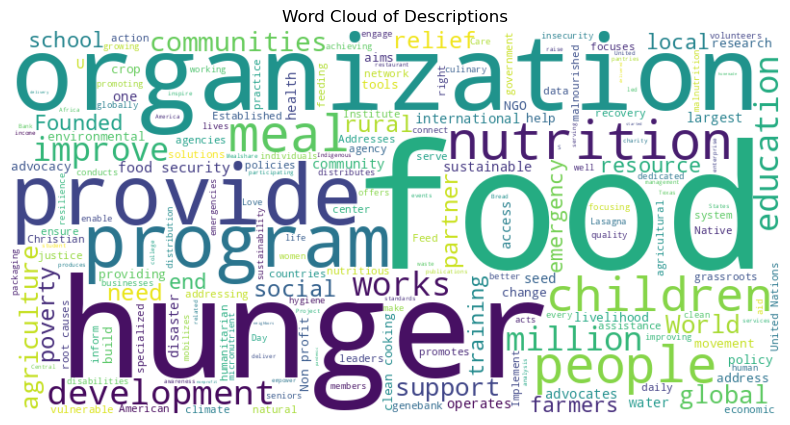

### Network Analysis

#### Network Graph: Organizations and Where They Operate

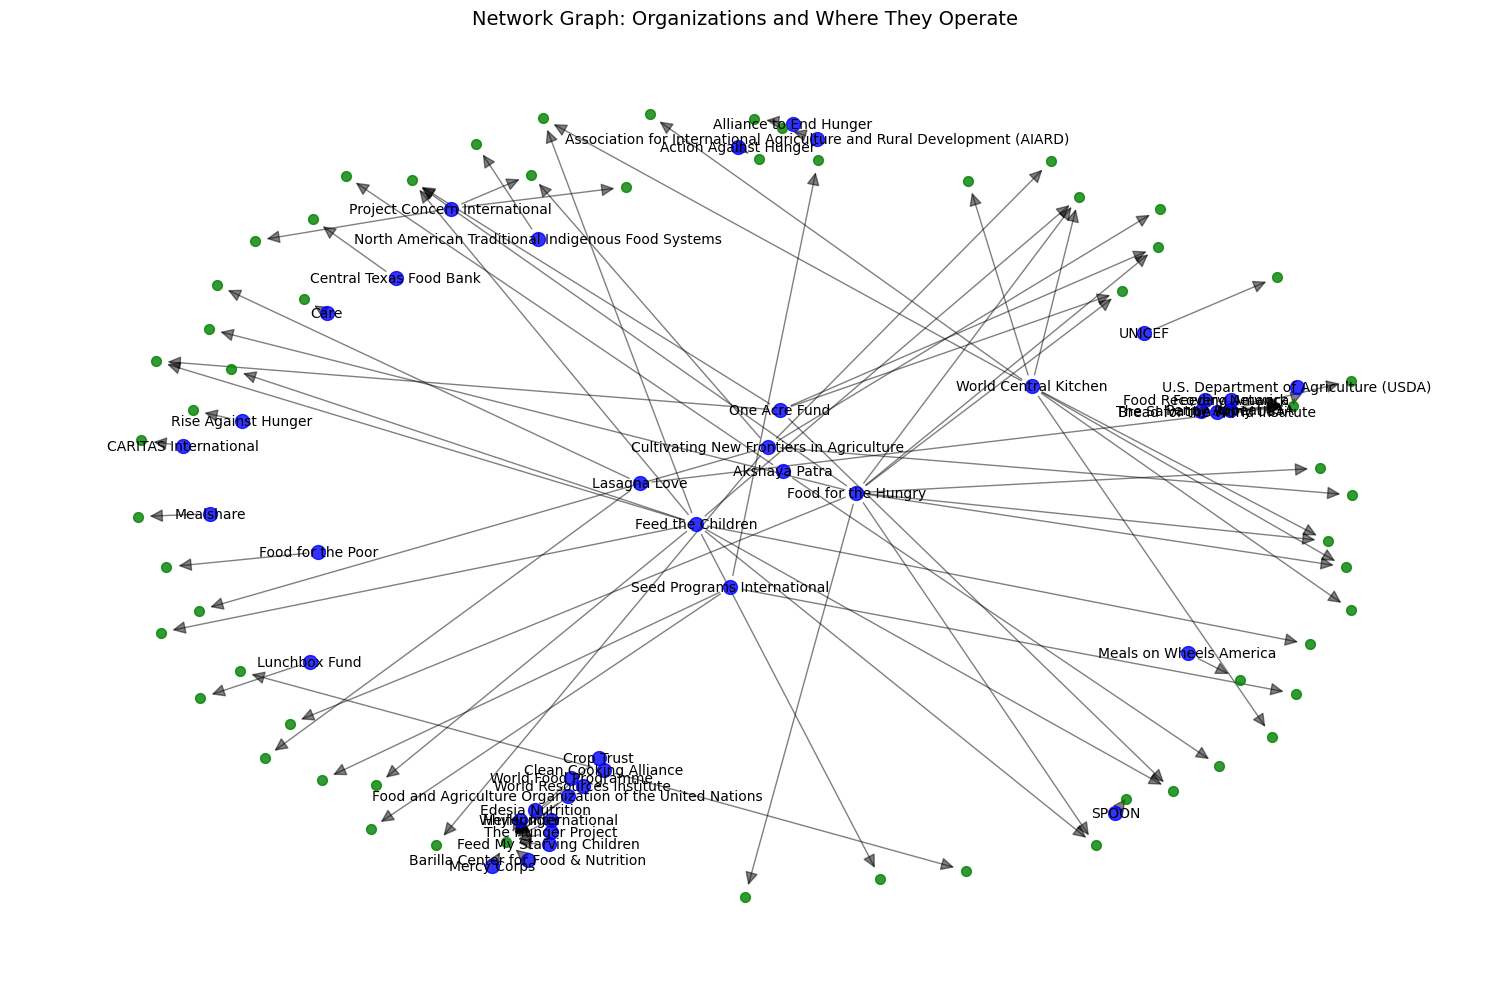

### Visualizations

#### Number of Organizations by Country/Region of Origin

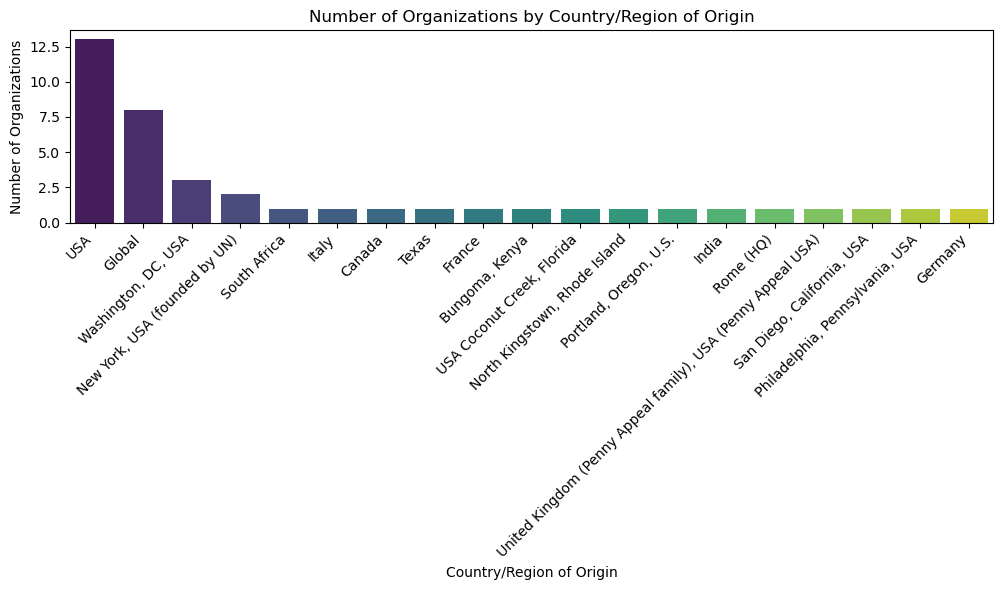

In [1]:
from IPython.display import display, Markdown
import os
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

def display_header(header, sub_header=None):
    display(Markdown(f'### {header}'))
    if sub_header:
        display(Markdown(f'#### {sub_header}'))

def print_directory_info():
    print("Current working directory: ", os.getcwd())
    print("Directory content: ", os.listdir())
    print("Directory content: ", os.listdir('/kaggle/input'))

def read_data(file_path):
    chunk_iter = pd.read_csv(file_path, chunksize=1000)
    data = pd.concat(chunk_iter)
    return data

def add_nodes(G, organization, countries_regions_operate):
    G.add_node(organization, node_type='organization')
    for country_region in countries_regions_operate:
        country_region = country_region.strip()
        G.add_node(country_region, node_type='country_region')

def add_edges(G, organization, countries_regions_operate):
    for country_region in countries_regions_operate:
        country_region = country_region.strip()
        G.add_edge(organization, country_region)

def draw_nodes(G, pos, organization_nodes, country_region_nodes):
    nx.draw_networkx_nodes(G, pos, nodelist=organization_nodes, node_color='blue', node_size=100, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, nodelist=country_region_nodes, node_color='green', node_size=50, alpha=0.8)

def draw_edges(G, pos):
    nx.draw_networkx_edges(G, pos, arrowsize=20, alpha=0.5)

def draw_labels(G, pos, organization_nodes):
    nx.draw_networkx_labels(G, pos, labels={n: n for n in organization_nodes}, font_size=10, font_color='black')

def create_graph(data):
    G = nx.DiGraph()
    for index, row in data.iterrows():
        organization = row['Organization Name']
        countries_regions_operate = row['Country/Region Where They Operate'].split(',')
        add_nodes(G, organization, countries_regions_operate)
        add_edges(G, organization, countries_regions_operate)

    pos = nx.spring_layout(G, seed=42) # Adding seed for reproducibility
    organization_nodes = [n for n, attr in G.nodes(data=True) if attr['node_type'] == 'organization']
    country_region_nodes = [n for n, attr in G.nodes(data=True) if attr['node_type'] == 'country_region']

    plt.figure(figsize=(15, 10))
    draw_nodes(G, pos, organization_nodes, country_region_nodes)
    draw_edges(G, pos)
    draw_labels(G, pos, organization_nodes)

    plt.title('Network Graph: Organizations and Where They Operate', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_organizations_by_origin(data, origin_column_name):
    origin_counts = data[origin_column_name].value_counts()
    origin_counts.index = origin_counts.index.str.strip()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=origin_counts.index, y=origin_counts.values, palette='viridis')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Country/Region of Origin')
    plt.ylabel('Number of Organizations')
    plt.title('Number of Organizations by Country/Region of Origin')
    plt.tight_layout()
    plt.show()

def plot_word_cloud(data, description_column_name):
    data[description_column_name] = data[description_column_name].astype(str)
    description_text = ' '.join(data[description_column_name].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(description_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Word Cloud of Descriptions')
    plt.show()

def main():
    display_header('Main Function and Execution', 'Print Directory Information')
    print_directory_info()
    
    file_path = '/kaggle/input/food-security-organizations-directory/food_security_global_orgs.csv'
    data = read_data(file_path)

    display_header('Visualizations', 'Word Cloud of Descriptions')
    plot_word_cloud(data, 'Description')

    display_header('Network Analysis', 'Network Graph: Organizations and Where They Operate')
    create_graph(data)

    display_header('Visualizations', 'Number of Organizations by Country/Region of Origin')
    origin_column_name = 'Country/Region of Origin'
    plot_organizations_by_origin(data, origin_column_name)

if __name__ == "__main__":
    main()

In [2]:
!pip install --quiet plotly

In [3]:
from IPython.display import Markdown
import geopandas as gpd
import pandas as pd
import re
from collections import Counter
import plotly.express as px

def display_header(header, sub_header=None):
    display(Markdown(f'### {header}'))
    if sub_header:
        display(Markdown(f'#### {sub_header}'))

def read_data(file_path):
    data = pd.read_csv(file_path)
    print("Data read successfully.")
    return data

def extract_countries(data):
    pattern = r'\b(?:USA|DR Congo|Bahamas|Canada|Australia|India|Guatemala|Haiti|Honduras|Kenya|Nicaragua|Malawi|Tanzania|Uganda|Ethiopia|El Salvador|Bangladesh|Bolivia|Burundi|Cambodia|Mozambique|Peru|Rwanda|Cuba|Zambia|Dominican Republic|South Africa)\b'
    country_counts = Counter()
    for country_region in data["Country/Region Where They Operate"]:
        countries = re.findall(pattern, country_region)
        country_counts.update(countries)
    country_counts_df = pd.DataFrame.from_dict(country_counts, orient='index', columns=['Count']).reset_index()
    country_counts_df.rename(columns={'index': 'Country'}, inplace=True)
    print("Countries extracted successfully.")
    return country_counts_df

def read_world_map(shapefile_path):
    world_map = gpd.read_file(shapefile_path)
    print("World map read successfully.")
    return world_map

def merge_world_data(country_counts_df, world_map):
    merged_world = world_map.merge(country_counts_df, left_on='SOVEREIGNT', right_on='Country', how='left')
    merged_world['Count'] = merged_world['Count'].fillna(0)
    print("World data merged successfully.")
    return merged_world

def plot_global_operations(merged_world):
    fig = px.choropleth(merged_world, geojson=merged_world.geometry, locations=merged_world.index, color='Count',
                        hover_name='SOVEREIGNT', color_continuous_scale='YlOrRd',
                        title='Global Reach of Food Security Organizations')
    fig.update_geos(fitbounds="locations", visible=False)
    print("Plot created successfully.")
    fig.show()

def main():
    shapefile_path = '/kaggle/input/food-security-organizations-directory/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
    file_path = '/kaggle/input/food-security-organizations-directory/food_security_global_orgs.csv'

    display_header('Read and Preprocess Data', 'Loading Data and Extracting Countries')
    data = read_data(file_path)
    country_counts_df = extract_countries(data)

    display_header('Read World Map and Merge Data', 'Reading Shapefile and Merging Data')
    world_map = read_world_map(shapefile_path)
    merged_world = merge_world_data(country_counts_df, world_map)

    print("Merged world DataFrame:")
    print(merged_world.head())

    display_header('Plot Global Operations', 'Visualizing Global Reach of Food Security Organizations')
    plot_global_operations(merged_world)

if __name__ == "__main__":
    main()

### Read and Preprocess Data

#### Loading Data and Extracting Countries

Data read successfully.
Countries extracted successfully.


### Read World Map and Merge Data

#### Reading Shapefile and Merging Data

World map read successfully.
World data merged successfully.
Merged world DataFrame:
        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  ...  \
0         0      2  Sovereign country   1                         Fiji  ...   
1         0      2  Sovereign country   1  United Republic of Tanzania  ...   
2         0      2      Indeterminate   1               Western Sahara  ...   
3         0      2  Sovereign country   1                       Canada  ...   
4         1      2            Country  

### Plot Global Operations

#### Visualizing Global Reach of Food Security Organizations

Plot created successfully.
